In [1]:
import keras.models
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from src.functions import initializers as ci # i.e., custom initializers
from src.functions.layers import ActivLin1D
from src.functions import activation_parameters as ap
from src.utils import data_handler as dh
import matplotlib.pyplot as plt

# Script to compare the outputs of the python and C++ inverse models to verify correctness

## Python Inverse Model Outputs

In [2]:
# Model save path:
inv_save_path = '/Users/francescomaraschin/Desktop/IntelligentVehicles/Project_NN_Conda/data/trained_models/inverse_model/inverse_model.h5'

inverse_model = tf.keras.models.load_model(filepath=inv_save_path,
                                            custom_objects={
                                                'MyInitializer': ci.MyInitializer,
                                                'ActivLin1D': ActivLin1D
                                            })

Metal device set to: Apple M1


2023-02-28 10:45:57.541501: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-28 10:45:57.541629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# Reshape and split data
inverse_dataset_path = '/Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/Data/csv/inverse_dataset.csv'
inverse_dataset = dh.load_csv(inverse_dataset_path)
train_data, valid_data, time = dh.window_data(dataset=inverse_dataset,
                                              input_labels=['acceleration',
                                                            'velocity'],
                                              output_labels=['pedal'],
                                              input_window=10,
                                              output_window=1,
                                              batch_size=100,
                                              validation_split=0.3)

In [4]:
# Calculate the predicted pedal from the python model
py_calculated_pedal = inverse_model.predict(train_data[0])

2023-02-28 10:45:59.847868: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-28 10:45:59.964379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


350/350 [==============================] - 3s 8ms/step


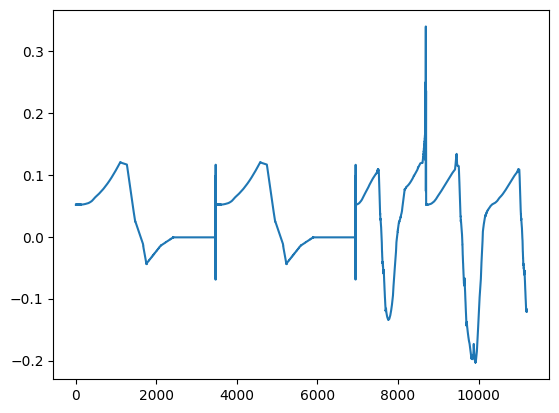

In [5]:
# plot
plt.plot(py_calculated_pedal)

## C++ model

In [6]:
# Need to make two csv files that contained the windowed velocities and accelerations.
acceleration = train_data[0][0]
velocity = train_data[0][1]
# noinspection PyTypeChecker
pd.DataFrame(acceleration).to_csv("/Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/NN_CPP/test_data/acceleration.csv",
                                  header=None,
                                  index=None ,
                                  lineterminator = '\n'
                                  )
# noinspection PyTypeChecker
pd.DataFrame(velocity).to_csv("/Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/NN_CPP/test_data/velocity.csv",
                              header=None,
                              index=None ,
                              lineterminator = '\n'
                              )

In [10]:
# After elaboration in the C++ network we have a CSV file containing the output of the C++ inverse NN model.
# Load this csv:

cpp_pedal_path = '/Users/francescomaraschin/Desktop/IntelligentVehicles/LongitudinalControllerNN/NN_CPP/cmake-build-debug/pedal_out_cpp.csv'
cpp_calculated_pedal = pd.read_csv(cpp_pedal_path)

# Remove weird NaN column
cpp_calculated_pedal = cpp_calculated_pedal.drop(columns='Unnamed: 1')

In [11]:
cpp_calculated_pedal

,0.037082
0,0.036918
1,0.037027
2,0.037226
3,0.037254
4,0.037094
...,...
11194,-0.670414
11195,-0.669190
11196,-0.667837
11197,-0.666583


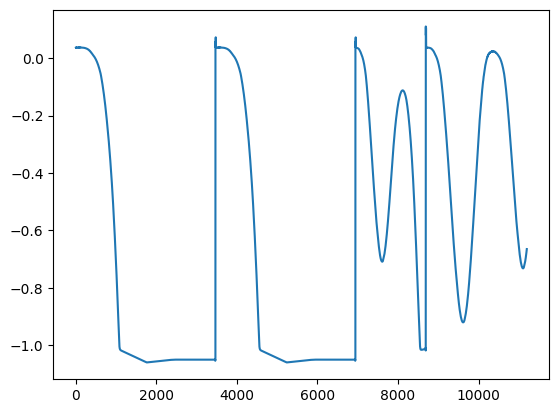

In [12]:
plt.plot(cpp_calculated_pedal)